In [23]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import timedelta

from cartoframes import read_carto, to_carto, has_table, list_tables
from cartoframes.auth import set_default_credentials, Credentials
#from cartoframes.viz import Map, Layer, basemaps
from shapely.geometry import Point, LineString
from zipfile import ZipFile

In [101]:
visits_df = pd.read_excel("INRIX Visits Panel Size - Oct 2020 to Sept 2021.xlsx") 

In [25]:
visits_df.columns

Index(['Date', 'Unique Devices'], dtype='object')

In [26]:
visits_df

,Date,Unique Devices
0,2020-10-01,25204444
1,2020-10-02,27069081
2,2020-10-03,30126289
3,2020-10-04,27928919
4,2020-10-05,30605973
...,...,...
360,2021-09-26,28559160
361,2021-09-27,28383915
362,2021-09-28,28422271
363,2021-09-29,28120455


In [279]:
visits_df['year'] = visits_df['Date'].dt.year

In [28]:
visits_df['month'] = visits_df['Date'].dt.month
visits_df['year_month'] = pd.to_datetime(visits_df['Date']).dt.to_period('M')


In [29]:
visits_df.year_month.unique()

<PeriodArray>
['2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04',
 '2021-05', '2021-06', '2021-07', '2021-08', '2021-09']
Length: 12, dtype: period[M]

In [30]:
print('Average number of devices per year:')
average_device_per_year = visits_df.sum()['Unique Devices']/len(visits_df.year.unique())
average_device_per_year

Average number of devices per year:


6131512354.5

In [31]:
print('Average number of devices per day per year:')
total_device_year = visits_df.groupby(by=['year']).sum()['Unique Devices']
number_of_days = visits_df['year'].value_counts()
annual_avg = pd.concat([total_device_year,number_of_days],axis=1)\
.rename(columns={'Unique Devices':'Sum of devices per year','year':'Total number of days'})
annual_avg['Average number of devices per day'] = round(annual_avg['Sum of devices per year']/annual_avg['Total number of days'],1)

annual_avg

Average number of devices per day per year:


,Sum of devices per year,Total number of days,Average number of devices per day
2020,2739637203,92,29778665.2
2021,9523387506,273,34884203.3


In [32]:
visits_df.groupby(by=['Date']).sum()['Unique Devices']

Date
2020-10-01    25204444
2020-10-02    27069081
2020-10-03    30126289
2020-10-04    27928919
2020-10-05    30605973
                ...   
2021-09-26    28559160
2021-09-27    28383915
2021-09-28    28422271
2021-09-29    28120455
2021-09-30    28833551
Name: Unique Devices, Length: 365, dtype: int64

In [33]:
print('Top 10 largest number of devices in a day:')
visits_df.groupby(by=['Date']).sum()['Unique Devices'].nlargest(10)

Top 10 largest number of devices in a day:


Date
2021-08-09    65475135
2021-08-08    61926635
2021-08-05    60774870
2021-08-23    58920116
2021-08-20    58869650
2021-08-21    58146786
2021-08-04    57615438
2021-08-01    57400027
2021-08-02    57110454
2021-08-18    56912915
Name: Unique Devices, dtype: int64

	Aggregate total number of devices:


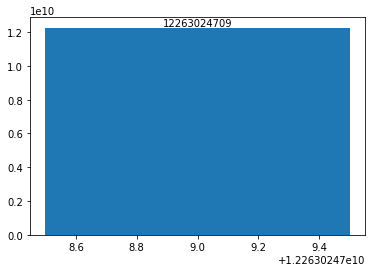

In [34]:
print('\tAggregate total number of devices:')
y = visits_df.sum()['Unique Devices']
fig, ax = plt.subplots(1, 1)
ax.bar(y, width=1,align='center', height=visits_df.sum()['Unique Devices'])
for bars in ax.containers:
    ax.bar_label(bars, fmt='%9.0f', size=10)
plt.show()

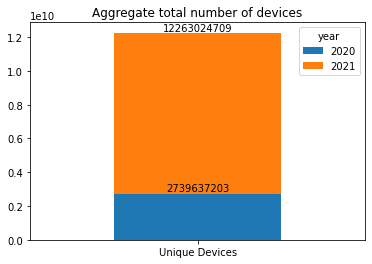

In [35]:
ax = pd.DataFrame(visits_df.groupby(by=['year']).sum()['Unique Devices']).T.plot.bar(stacked=True, rot=0, title='Aggregate total number of devices')
for bars in ax.containers:
    ax.bar_label(bars, fmt='%9.0f', size=10)

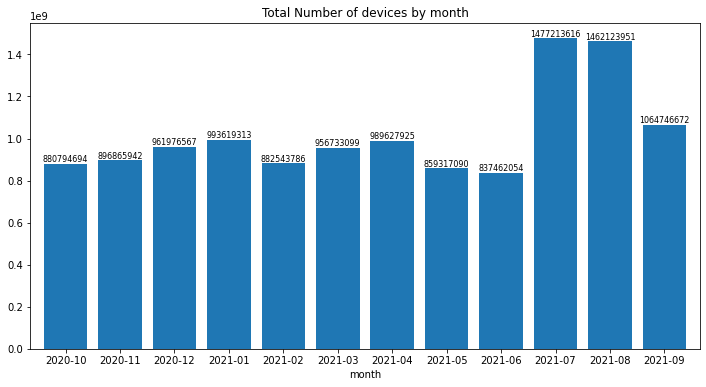

In [36]:
ax = visits_df.groupby(by=['year_month']).sum()['Unique Devices'].plot.bar(figsize=(12, 6), width=0.8, linewidth=0.2, title='Total Number of devices by month', rot=0, xlabel='month') 
for bars in ax.containers:
    ax.bar_label(bars, fmt='%9.0f', size=8)

In [45]:
visits_df

,Date,Unique Devices,year,month,year_month,day_of_week
0,2020-10-01,25204444,2020,10,2020-10,Thursday
1,2020-10-02,27069081,2020,10,2020-10,Friday
2,2020-10-03,30126289,2020,10,2020-10,Saturday
3,2020-10-04,27928919,2020,10,2020-10,Sunday
4,2020-10-05,30605973,2020,10,2020-10,Monday
...,...,...,...,...,...,...
360,2021-09-26,28559160,2021,9,2021-09,Sunday
361,2021-09-27,28383915,2021,9,2021-09,Monday
362,2021-09-28,28422271,2021,9,2021-09,Tuesday
363,2021-09-29,28120455,2021,9,2021-09,Wednesday


In [76]:
from pandas.api.types import CategoricalDtype
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
visits_df['day_of_week'] = visits_df['Date'].dt.day_name()
visits_df['day_of_week'] = visits_df['day_of_week'].astype(cat_type)


In [77]:
visits_df_2020 = visits_df[visits_df['year']==2020]
visits_df_2021 = visits_df[visits_df['year']==2021]

### Sum of Devices per day

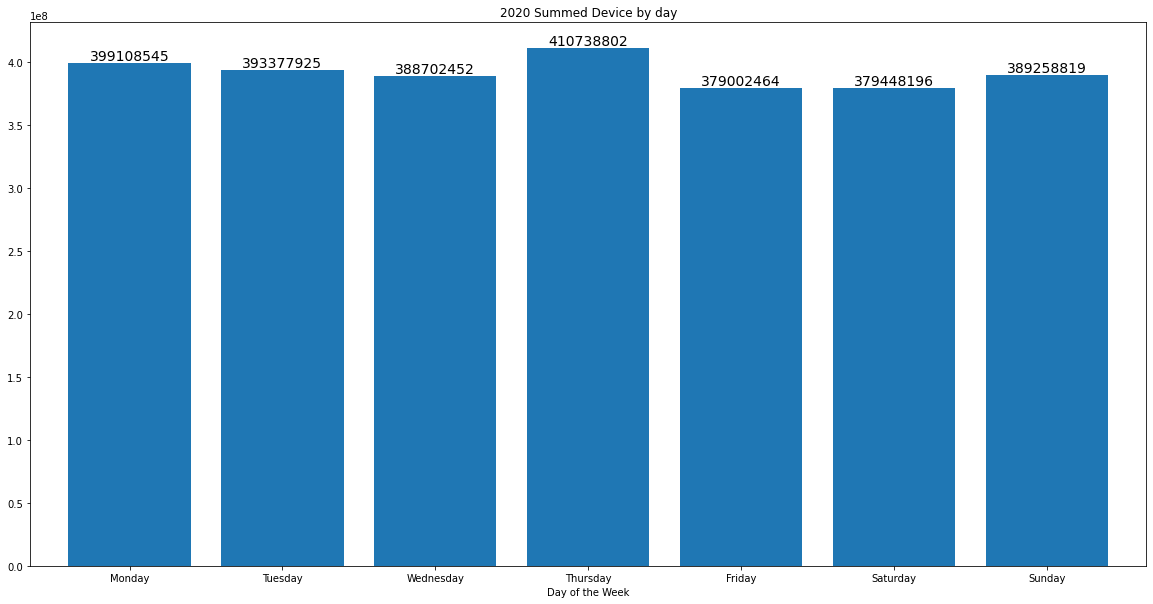

In [79]:
ax = visits_df_2020.groupby(by=['day_of_week']).sum()['Unique Devices'].plot.bar(figsize=(20, 10), width=0.8, linewidth=0.2, title='2020 Summed Device by day', rot=0, xlabel='Day of the Week')
for bars in ax.containers:
    ax.bar_label(bars, fmt='%9.0f', size=14)

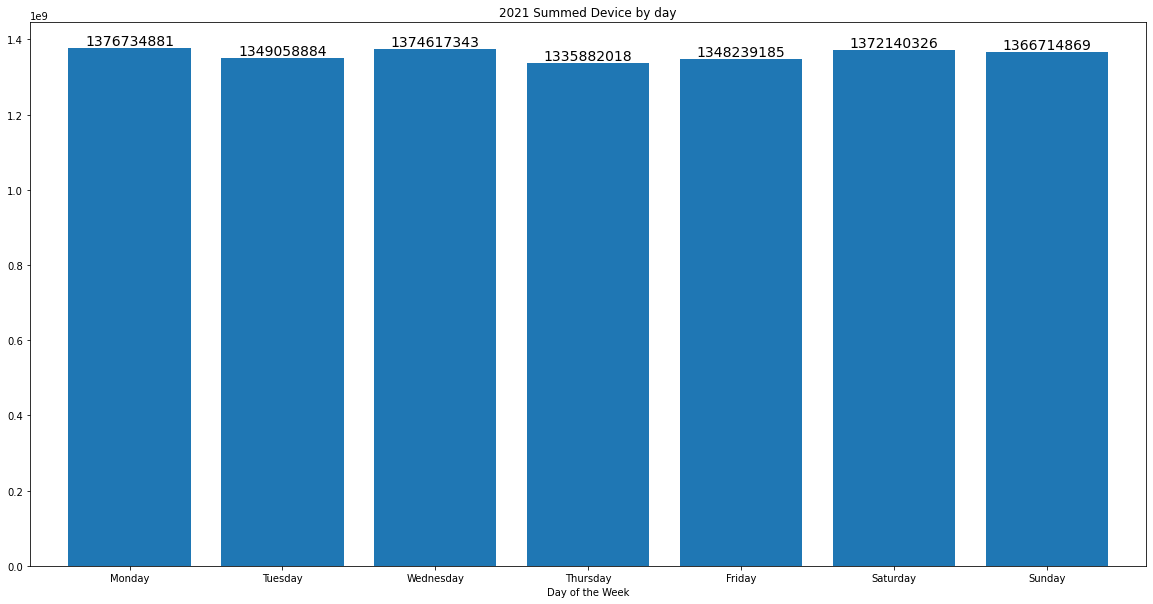

In [80]:
ax = visits_df_2021.groupby(by=['day_of_week']).sum()['Unique Devices'].plot.bar(figsize=(20, 10), width=0.8, linewidth=0.2, title='2021 Summed Device by day', rot=0, xlabel='Day of the Week')
for bars in ax.containers:
    ax.bar_label(bars, fmt='%9.0f', size=14)

In [88]:
Average_devices_per_day_2020 = visits_df_2020.sum()['Unique Devices']/len(visits_df_2020)
Average_devices_per_day_2021 = visits_df_2021.sum()['Unique Devices']/len(visits_df_2021)

In [94]:
print('Number of days with data in 2020: '+ str(len(visits_df_2020['Date'].unique())))
print('Number of days with data in 2021: '+ str(len(visits_df_2021['Date'].unique())))

Number of days with data in 2020: 92
Number of days with data in 2021: 273


In [97]:
average_2020_365_estimate = visits_df_2020.sum()['Unique Devices']/365
average_2021_365_estimate = visits_df_2021.sum()['Unique Devices']/365

In [176]:
# print('Using 365 days, the average number of devices per day is:')
# print('Average number of unique devices per day in 2020: '+ str(average_2020_365_estimate))
# print('Average number of unique devices per day in 2021: '+ str(average_2021_365_estimate))

### Average number of devices per year + day

In [100]:
print('Based on the number of days with data provided, the average number of devices per day is:\n')
print('Average number of unique devices per day in 2020: '+ str(Average_devices_per_day_2020))
print('Average number of unique devices per day in 2021: '+ str(Average_devices_per_day_2021))

Based on the number of days with data provided, the average number of devices per day is:

Average number of unique devices per day in 2020: 29778665.25
Average number of unique devices per day in 2021: 34884203.31868132


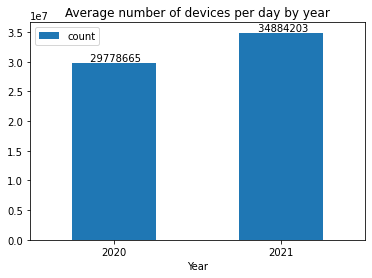

In [312]:
bar_df = pd.DataFrame({'Year':['2020', '2021'], 'count':[Average_devices_per_day_2020, Average_devices_per_day_2021]})
ax = bar_df.plot.bar(x='Year', y='count', rot=0, title='Average number of devices per day by year')
for bars in ax.containers:
    ax.bar_label(bars, fmt='%9.0f', size=10)

In [283]:
print('Average number of devices per year:')
visits_df.sum()['Unique Devices']/len(visits_df['year'].unique())

Average number of devices per year:


6131512354.5

### Population Analysis

In [167]:
xls = pd.ExcelFile('INRIX_device_count_by_county.xlsx')
county_data = pd.read_excel(xls, 'INRIX')
df2 = pd.read_excel(xls, 'CO-EST2021-POP')

Index(['year_month_day', 'census_05', 'census_05_leadingzero', 'combined name',
       'normalization_factor', 'population', 'Unnamed: 6', 'Ratio',
       'without NA's', 'Unnamed: 9', 'Average Ratio', 'Unnamed: 11',
       'SumDevices/SumPop'],
      dtype='object')

### April 18, 2018 population 

In [132]:
county_data.columns

,year_month_day,census_05,census_05_leadingzero,combined name,normalization_factor,population,Unnamed: 6,Ratio,without NA's,Unnamed: 9,Average Ratio,Unnamed: 11,SumDevices/SumPop,0,1


In [134]:
county_data = pd.concat([county_data, county_data['combined name'].str.split(', ', expand=True)], axis=1)

In [135]:
county_data.columns

Index([       'year_month_day',             'census_05',
       'census_05_leadingzero',         'combined name',
        'normalization_factor',            'population',
                  'Unnamed: 6',                 'Ratio',
                'without NA's',            'Unnamed: 9',
               'Average Ratio',           'Unnamed: 11',
           'SumDevices/SumPop',                       0,
                             1],
      dtype='object')

In [146]:
county_data= county_data.rename(columns={0: "County", 1: "State"})

In [147]:
county_data.columns

Index(['year_month_day', 'census_05', 'census_05_leadingzero', 'combined name',
       'normalization_factor', 'population', 'Unnamed: 6', 'Ratio',
       'without NA's', 'Unnamed: 9', 'Average Ratio', 'Unnamed: 11',
       'SumDevices/SumPop', 'County', 'State'],
      dtype='object')

In [116]:
bool_series = pd.notnull(county_data["combined name"])

In [122]:
len(county_data[bool_series])

3136

In [121]:
len(county_data[pd.isnull(county_data["combined name"])])

85

In [137]:
county_data = county_data[county_data['combined name'].notna()]

In [138]:
len(county_data)

3136

In [160]:
total_population = county_data.sum()['population']
print('Total population in the US: ' + str(total_population))

Total population in the US: 315196157.0


In [166]:
print('As of April 18, 2018, sum of total population by County\nNote: If number is 0, it means population data is not provided')
county_data.groupby(by=['County']).sum()['population'] 


As of April 18, 2018, sum of total population by County
Note: If number is 0, it means population data is not provided


County
Abbeville County         24299.0
Acadia County                0.0
Accomack County          33246.0
Ada County              511931.0
Adair County             71072.0
                          ...   
Yukon Koyukuk County         0.0
Yuma County             216931.0
Zapata County            13908.0
Zavala County             9534.0
Ziebach County            2380.0
Name: population, Length: 1843, dtype: float64

In [162]:
DC = county_data[county_data['State']=='District of Columbia']

In [165]:
print('As of April 18, 2018, sum of total population by State:\nNote: If number is 0, it means population data is not provided')
county_data.groupby(by=['State']).sum()['population'] 

As of April 18, 2018, sum of total population by State:
Note: If number is 0, it means population data is not provided


State
Alabama                  4875316.0
Alaska                         0.0
Arizona                  7276316.0
Arkansas                 2994541.0
California              39237836.0
Colorado                 5812069.0
Connecticut              3605597.0
Delaware                 1003384.0
District of Columbia           0.0
Florida                 21110675.0
Georgia                 10041848.0
Hawaii                   1441471.0
Idaho                    1900923.0
Illinois                11267068.0
Indiana                  6378050.0
Iowa                     3179064.0
Kansas                   2934582.0
Kentucky                 4509394.0
Louisiana                      0.0
Maine                    1372247.0
Maryland                 4468059.0
Massachusetts            6984723.0
Michigan                 9830000.0
Minnesota                5508208.0
Mississippi              2761332.0
Missouri                 4372204.0
Montana                  1104271.0
Nebraska                 1963692.0
Nevada        

In [143]:
county_data.columns

Index([       'year_month_day',             'census_05',
       'census_05_leadingzero',         'combined name',
        'normalization_factor',            'population',
                  'Unnamed: 6',                 'Ratio',
                'without NA's',            'Unnamed: 9',
               'Average Ratio',           'Unnamed: 11',
           'SumDevices/SumPop',                       0,
                             1],
      dtype='object')

In [163]:
county_data.columns

Index(['year_month_day', 'census_05', 'census_05_leadingzero', 'combined name',
       'normalization_factor', 'population', 'Unnamed: 6', 'Ratio',
       'without NA's', 'Unnamed: 9', 'Average Ratio', 'Unnamed: 11',
       'SumDevices/SumPop', 'County', 'State'],
      dtype='object')

#### 2020 & 2021 Population

In [251]:
df2 = pd.read_excel(xls, 'CO-EST2021-POP')
df2 = df2.iloc[4: , 1:-2]
# drop non county/state related data
df2 = df2.iloc[:-5 , :]

In [252]:
df2

,table with row headers in column A and column headers in rows 3 through 4 (leading dots indicate sub-parts),Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
4,".Autauga County, Alabama",NaN,58805,58877,59095.0
5,".Baldwin County, Alabama",NaN,231767,233140,239294.0
6,".Barbour County, Alabama",NaN,25223,25180,24964.0
7,".Bibb County, Alabama",NaN,22293,22223,22477.0
8,".Blount County, Alabama",NaN,59134,59081,59041.0
...,...,...,...,...,...
3142,".Sweetwater County, Wyoming",NaN,42272,42158,41614.0
3143,".Teton County, Wyoming",NaN,23331,23347,23575.0
3144,".Uinta County, Wyoming",NaN,20450,20441,20635.0
3145,".Washakie County, Wyoming",NaN,7685,7658,7705.0


In [253]:
df2= df2.rename(columns={'table with row headers in column A and column headers in rows 3 through 4 (leading dots indicate sub-parts)': "County+State", 'Unnamed: 3': "April 1, 2020 Estimates Base", 'Unnamed: 4':'2020 population', 'Unnamed: 5':'2021 population'})
df2=df2.drop(['Unnamed: 2'], axis=1)

In [254]:
pop_data = pd.concat([df2, df2['County+State'].str.split(', ', expand=True)], axis=1)
pop_data = pop_data.rename(columns = {0:'County', 1:'State'})

pop_data['County'] = pop_data['County'].str.replace(r'.', '')
pop_data = pop_data.astype({"2020 population": int, "2021 population": int})

<ipython-input-254-bc3fed921c1f>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  pop_data['County'] = pop_data['County'].str.replace(r'.', '')


In [266]:
pop_data

,County+State,"April 1, 2020 Estimates Base",2020 population,2021 population,County,State
4,".Autauga County, Alabama",58805,58877,59095,Autauga County,Alabama
5,".Baldwin County, Alabama",231767,233140,239294,Baldwin County,Alabama
6,".Barbour County, Alabama",25223,25180,24964,Barbour County,Alabama
7,".Bibb County, Alabama",22293,22223,22477,Bibb County,Alabama
8,".Blount County, Alabama",59134,59081,59041,Blount County,Alabama
...,...,...,...,...,...,...
3142,".Sweetwater County, Wyoming",42272,42158,41614,Sweetwater County,Wyoming
3143,".Teton County, Wyoming",23331,23347,23575,Teton County,Wyoming
3144,".Uinta County, Wyoming",20450,20441,20635,Uinta County,Wyoming
3145,".Washakie County, Wyoming",7685,7658,7705,Washakie County,Wyoming


In [256]:
pop_data.columns

Index(['County+State', 'April 1, 2020 Estimates Base', '2020 population',
       '2021 population', 'County', 'State'],
      dtype='object')

In [258]:
print('In 2020, sum of total population by County\nNote: If number is 0, it means population data is not provided')
pop_data.groupby(by=['County']).sum()['2020 population'] 

In 2020, sum of total population by County
Note: If number is 0, it means population data is not provided


County
Abbeville County              24212
Acadia Parish                 57455
Accomack County               33348
Ada County                   497984
Adair County                  71008
                              ...  
Yukon-Koyukuk Census Area      5300
Yuma County                  214416
Zapata County                 13884
Zavala County                  9652
Ziebach County                 2388
Name: 2020 population, Length: 1878, dtype: int64

In [259]:
print('In 2021, sum of total population by County\nNote: If number is 0, it means population data is not provided')
pop_data.groupby(by=['County']).sum()['2021 population'] 

In 2021, sum of total population by County
Note: If number is 0, it means population data is not provided


County
Abbeville County              24299
Acadia Parish                 57288
Accomack County               33246
Ada County                   511931
Adair County                  71072
                              ...  
Yukon-Koyukuk Census Area      5275
Yuma County                  216931
Zapata County                 13908
Zavala County                  9534
Ziebach County                 2380
Name: 2021 population, Length: 1878, dtype: int64

In [262]:
print('2020, sum of total population by State')
pop_data.groupby(by=['State']).sum()['2020 population'] 

2020, sum of total population by State



State
Alabama                  5024803
Alaska                    732441
Arizona                  7177986
Arkansas                 3012232
California              39499738
Colorado                 5784308
Connecticut              3600260
Delaware                  991886
District of Columbia      690093
Florida                 21569932
Georgia                 10725800
Hawaii                   1451911
Idaho                    1847772
Illinois                12785245
Indiana                  6785644
Iowa                     3188669
Kansas                   2935880
Kentucky                 4503958
Louisiana                4651203
Maine                    1362280
Maryland                 6172679
Massachusetts            7022220
Michigan                10067664
Minnesota                5707165
Mississippi              2956870
Missouri                 6154481
Montana                  1086193
Nebraska                 1961455
Nevada                   3114071
New Hampshire            1377848
New 

In [271]:
print('In 2021, the sum of total population by State:')
pop_data.groupby(by=['State']).sum()['2021 population'] 

In 2021, the sum of total population by State:


State
Alabama                  5039877
Alaska                    732673
Arizona                  7276316
Arkansas                 3025891
California              39237836
Colorado                 5812069
Connecticut              3605597
Delaware                 1003384
District of Columbia      670050
Florida                 21781128
Georgia                 10799566
Hawaii                   1441553
Idaho                    1900923
Illinois                12671469
Indiana                  6805985
Iowa                     3193079
Kansas                   2934582
Kentucky                 4509394
Louisiana                4624047
Maine                    1372247
Maryland                 6165129
Massachusetts            6984723
Michigan                10050811
Minnesota                5707390
Mississippi              2949965
Missouri                 6168187
Montana                  1104271
Nebraska                 1963692
Nevada                   3143991
New Hampshire            1388992
New 

In [269]:
total_2020_pop = pop_data['2020 population'].sum()
print('Total population in the US in 2020 :'+ str(total_2020_pop))

total_2021_pop = pop_data['2021 population'].sum()
print('\nTotal population in the US in 2021 :'+ str(total_2021_pop))

average_pop = (total_2020_pop+total_2021_pop)/2
print('\nAverage population per year: '+ str(average_pop))

Total population in the US in 2020 :331501080

Total population in the US in 2021 :331893745

Average population per year: 331697412.5


In [274]:
print('In 2020, the average total population by State per day:')
pop_data.groupby(by=['State']).sum()['2020 population'] /365

In 2020, the average total population by State per day:


State
Alabama                  13766.583562
Alaska                    2006.687671
Arizona                  19665.715068
Arkansas                  8252.690411
California              108218.460274
Colorado                 15847.419178
Connecticut               9863.726027
Delaware                  2717.495890
District of Columbia      1890.665753
Florida                  59095.704110
Georgia                  29385.753425
Hawaii                    3977.838356
Idaho                     5062.389041
Illinois                 35028.068493
Indiana                  18590.805479
Iowa                      8736.079452
Kansas                    8043.506849
Kentucky                 12339.610959
Louisiana                12743.021918
Maine                     3732.273973
Maryland                 16911.449315
Massachusetts            19238.958904
Michigan                 27582.641096
Minnesota                15636.068493
Mississippi               8101.013699
Missouri                 16861.591781
Montan

In [273]:
print('In 2021, the average total population by State per day:')
pop_data.groupby(by=['State']).sum()['2021 population'] /365

In 2020, the average total population by State per day:
In 2021, the average total population by State per day:


State
Alabama                  13807.882192
Alaska                    2007.323288
Arizona                  19935.112329
Arkansas                  8290.112329
California              107500.920548
Colorado                 15923.476712
Connecticut               9878.347945
Delaware                  2748.997260
District of Columbia      1835.753425
Florida                  59674.323288
Georgia                  29587.852055
Hawaii                    3949.460274
Idaho                     5208.008219
Illinois                 34716.353425
Indiana                  18646.534247
Iowa                      8748.161644
Kansas                    8039.950685
Kentucky                 12354.504110
Louisiana                12668.621918
Maine                     3759.580822
Maryland                 16890.764384
Massachusetts            19136.227397
Michigan                 27536.468493
Minnesota                15636.684932
Mississippi               8082.095890
Missouri                 16899.142466
Montan

In [286]:
print('The average population by State per year is:')
(pop_data.groupby(by=['State']).sum()['2020 population'] + pop_data.groupby(by=['State']).sum()['2021 population'])/2

The average population by State per year is:


State
Alabama                  5032340.0
Alaska                    732557.0
Arizona                  7227151.0
Arkansas                 3019061.5
California              39368787.0
Colorado                 5798188.5
Connecticut              3602928.5
Delaware                  997635.0
District of Columbia      680071.5
Florida                 21675530.0
Georgia                 10762683.0
Hawaii                   1446732.0
Idaho                    1874347.5
Illinois                12728357.0
Indiana                  6795814.5
Iowa                     3190874.0
Kansas                   2935231.0
Kentucky                 4506676.0
Louisiana                4637625.0
Maine                    1367263.5
Maryland                 6168904.0
Massachusetts            7003471.5
Michigan                10059237.5
Minnesota                5707277.5
Mississippi              2953417.5
Missouri                 6161334.0
Montana                  1095232.0
Nebraska                 1962573.5
Nevada        

In [309]:
# ax = ((pop_data.groupby(by=['State']).sum()['2020 population'] + pop_data.groupby(by=['State']).sum()['2021 population'])/2).plot.bar(figsize=(100, 30), width=0.8, linewidth=0.2, title='Average Population by State per year', rot=0, xlabel='State', fontsize=30)

# plt.xlabel('xlabel', fontsize=18)

In [292]:
average_2020_pop = pop_data.sum()['2020 population']/pop_data['State'].nunique()
average_2021_pop = pop_data.sum()['2021 population']/pop_data['State'].nunique()
print('In the United States, the average population for in a state in 2020 is '+ str(average_2020_pop))
print('In the United States, the average population for in a state in 2020 is '+ str(average_2021_pop))

In the United States, the average population for in a state in 2020 is 6500021.176470588
In the United States, the average population for in a state in 2020 is 6507720.490196078


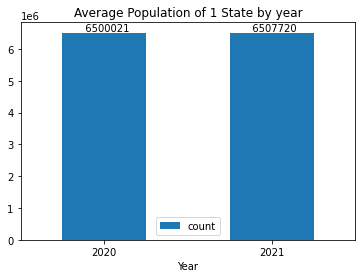

In [313]:
bar_df = pd.DataFrame({'Year':['2020', '2021'], 'count':[average_2020_pop, average_2021_pop]})
ax = bar_df.plot.bar(x='Year', y='count', rot=0, title='Average Population of 1 State by year')
for bars in ax.containers:
    ax.bar_label(bars, fmt='%9.0f', size=10)